## An Analysis of Data from Project Gutenburg
#### Jakob Forde

The purpose of this project was to look at data available on the Project Gutenberg website. This website is the largest e-library with over 60,000 copyright-free books on it, and I thought it would be interesting to explore the data and see what insights I can gleam. As for how the data was collected, I used simple web scraping with requests in order to grab key information from each book from the website. I then wrote it all to a CSV file so it could be parsed, explored, and plotted. The entire csv file is present in this repository. For an abridged version and what the structure of the data is, look at the README. 

In [36]:
import pandas as pd
from matplotlib import pyplot as plt
from collections import OrderedDict
import warnings

warnings.filterwarnings('ignore')
df = pd.read_csv('gutenberg.csv')

## Total and Top

Before getting into any charts, I thought it would be valuable to take a look at the top 5 most downloaded books as well as the top 5 most common authors represented on the site. Publically, the website only displays downloads in the past 30 days, so that is the metric I'm using to get the 5 most downloaded books. Note that the top 2 "authors" as actually "Various" and "Anonymous." Since that's not very interesting, I decided to skip those two.

In [37]:
print('TOP BOOKS')
print(df.sort_values(by='Num_Downloads', ascending=False)[0:5][['Title', 'Author', 'Num_Downloads']].to_string(index=False))
print('\n\nTOP AUTHORS')
print(df['Author'].value_counts()[2:7].to_string())


TOP BOOKS
                                  Title                      Author  Num_Downloads
Frankenstein; Or, The Modern Prometheus Mary Wollstonecraft Shelley          64647
                    Pride and Prejudice                 Jane Austen          48940
      The Adventures of Sherlock Holmes          Arthur Conan Doyle          22116
       Alice's Adventures in Wonderland               Lewis Carroll          21734
                       The Great Gatsby         F. Scott Fitzgerald          19663


TOP AUTHORS
William Shakespeare                  316
Mark Twain                           232
Baron Edward Bulwer Lytton Lytton    205
Georg Ebers                          173
Charles Dickens                      169


Not too surprising  -- all of the authors and books are fairly famous. I was surprised by the sheer number of downloads just in the past 30 days for the top books. I wanted to see how many downloads the site has gotten in total over the last 30 days, which is very easy to do with pandas. I also just wanted to see how many books were on the site when I scraped. 

In [38]:
print('Total Downloads in Past 30 Days: {:,}'.format(df['Num_Downloads'].sum()))
print('Total Number of Books on Website: {:,}'.format(len(df)))

Total Downloads in Past 30 Days: 4,136,949
Total Number of Books on Website: 67,368


## Pie Charts

Next, I wanted to take a look at some pie charts to see how the distribution of different attributes on the website looked like. First up, I wanted to explore genres. There are thousands upon thousands of unique genres, so a complete pie chart would be indecipherable. Therefore, I decided to pick only some of the top genres and then lump everything else into an "other" category. Below is the result for genres: 

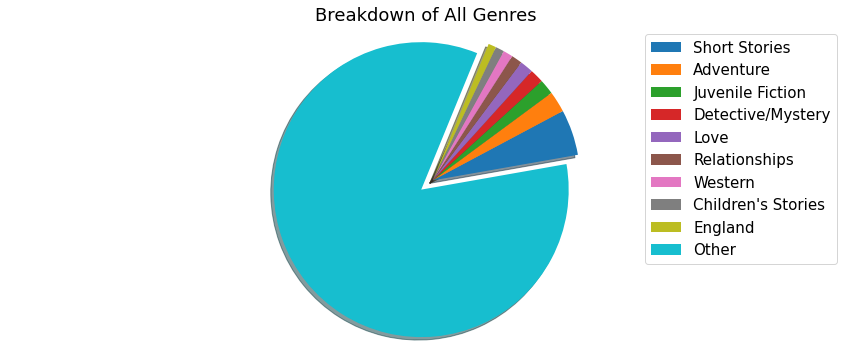

In [39]:
fig1, ax1 = plt.subplots(1, 1, figsize=(15, 6))
plt.rc('font', size=15)
explode = (0, 0, 0, 0, 0, 0, 0, 0, 0, 0.1)

subject_counts = (df['Subject1'].value_counts() + df['Subject2'].value_counts() + df['Subject3'].value_counts()).dropna().sort_values(ascending=False).reset_index()
subject_counts.rename(columns={'index' : 'Subject', 0:'Count'}, inplace=True)
num_displayable = 9
other = 0
for index, row in subject_counts[num_displayable+1:].iterrows():
    other += int(row['Count'])

ax1.pie(subject_counts['Count'][:num_displayable].to_list() + [other], startangle=10, explode=explode, shadow = True)
ax1.set_title('Breakdown of All Genres')
ax1.axis('equal')
ax1.legend(['Short Stories', 'Adventure', 'Juvenile Fiction', 'Detective/Mystery', 'Love', 'Relationships', 'Western', 'Children\'s Stories', 'England',  'Other']);

As we can see, there are quite a few genres represented on the website! The largest genre covers less than an 8th of the total number of books on the site. Fortunately, the pie chart of languages provides a much more 

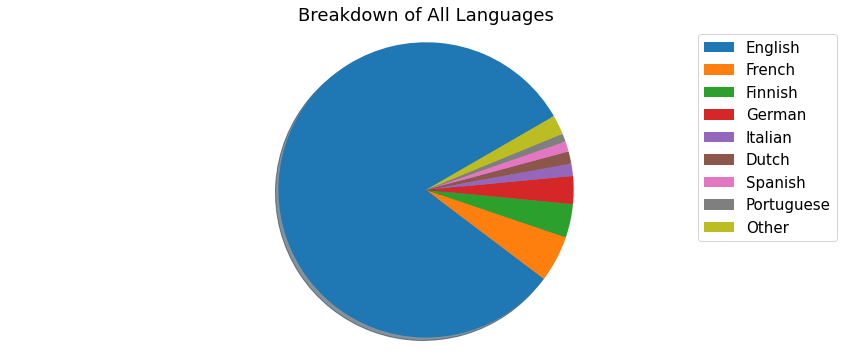

In [40]:
language_counts = df['Language'].value_counts().dropna().reset_index()
language_counts.rename(columns={'index': 'Language', 'Language' : 'Count'}, inplace=True)
num_displayable = 8
other = 0
for index, row in language_counts[num_displayable+1:].iterrows():
    other+= int(row['Count'])

fig2, ax2 = plt.subplots(1, 1, figsize=(15, 6))
ax2.pie(language_counts[:num_displayable]['Count'].to_list() + [other], startangle=30, shadow = True)
ax2.axis('equal')
ax2.set_title('Breakdown of All Languages')
ax2.legend(labels=language_counts[:num_displayable]['Language'].to_list() + ['Other']);

No surprise here that English would be the most common language; however, I was surprised that French was the second most common language (not Spanish or Chinese). In fact, Spanish is only the 7th most common language and Chinese is not even displayable. 

## Language Breakdown

Using language as a divider, I wanted to look at a variety of different attributes. Below, I created violin plots for the number of downloads for the most common languages. I had to divide up between English and non-English, since English was so much higher than the others. For the non-English books, I only considered books with 100 downloads or more, as there were many books that had 0 downloads and would not be helpful for the purposes of this chart. For the English chart, I decided a good threshold would be 1000, otherwise the chart would not be that useful.

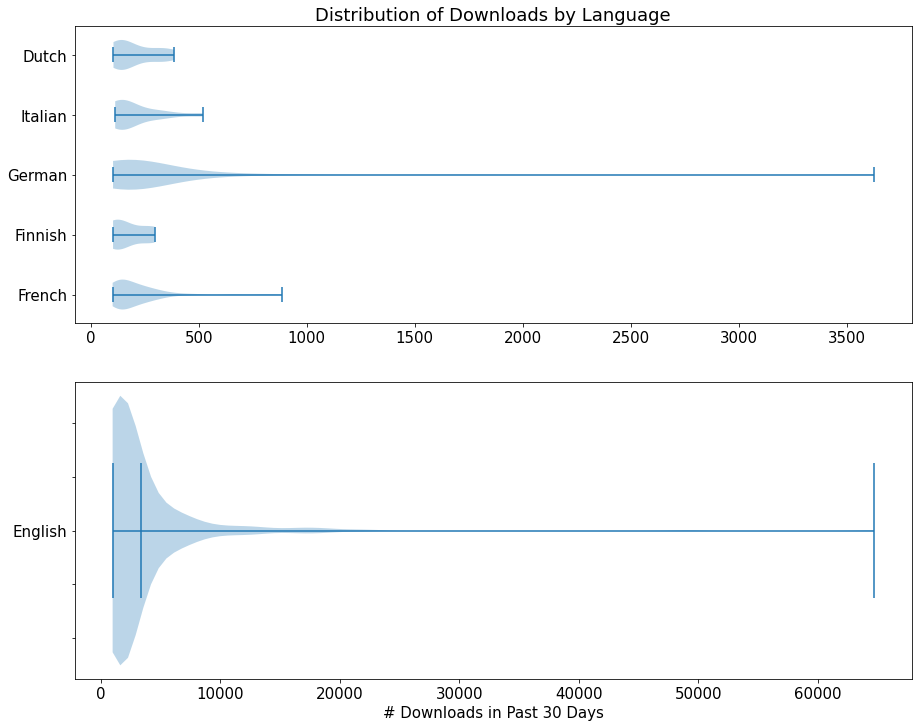

In [41]:
violin_list = []
languages = ['French', 'Finnish', 'German', 'Italian', 'Dutch']
for language in languages:
    violin_list.append(df[(df['Language'] == language) & (df['Num_Downloads'] > 100)]['Num_Downloads'].tolist())
fig3, ax3 = plt.subplots(2, 1, figsize=(15, 12))
ax3[0].violinplot(violin_list, vert=False)
ax3[0].set_title('Distribution of Downloads by Language')
ax3[0].set_yticklabels([''] + languages)
ax3[1].set_xlabel('# Downloads in Past 30 Days')
ax3[1].set_yticklabels(['', '', '', 'English', '', ''])
ax3[1].violinplot(df[(df['Language'] == 'English') & (df['Num_Downloads'] > 1000)]['Num_Downloads'], showmeans=True, vert=False);

As we can see, all the distributions look relatively the same, with a large number of books getting not too many downloads, with very few books getting a very lage number of downloads. Now, we can look at the average book length by language. Unfortuantely, given the nature of how Gutenburg displays their books, it was sometimes difficult to get an estimation of the number of words of the book. Therefore, some entires claim that the book has 0 or 17 words in it. This happens when there is some unaccounted-for way that the header and footer are being displayed -- my algorithm was unable to handle these books. Fortuantely, this didn't happen to often so the data should still be relatively accurate.

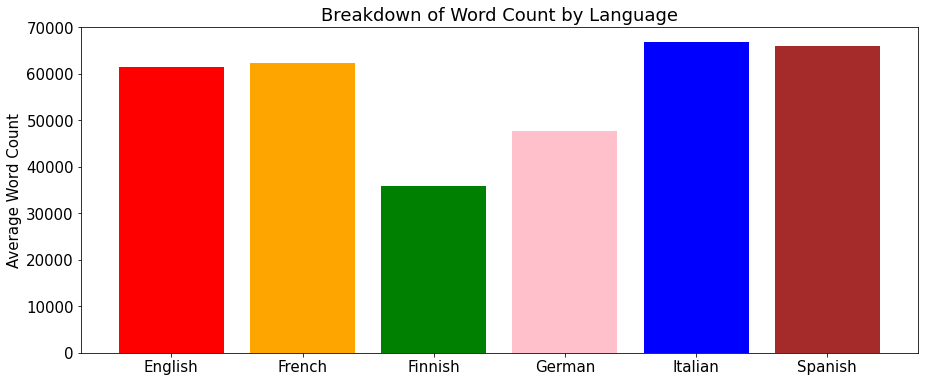

In [42]:
language_dict = {}
c = ['red', 'orange', 'green', 'pink', 'blue', 'brown']
for language in ['English', 'French', 'Finnish', 'German', 'Italian', 'Spanish']:
    language_dict[language] = df[(df['Language'] == language) & (df['Word_Count'] != 17) & (df['Word_Count'] != 0)]['Word_Count'].mean()

fig4, ax4 = plt.subplots(1, 1, figsize=(15, 6))
ax4.bar(['English', 'French', 'Finnish', 'German', 'Italian', 'Spanish'], language_dict.values(), color = c)
ax4.set_ylabel('Average Word Count')
ax4.set_title('Breakdown of Word Count by Language');

Lastly in this section, I would like to take a look at demand by language. To do this, for each language, I will divide the number of total downloads by the number of books to see which languages are in high demand on the site. 

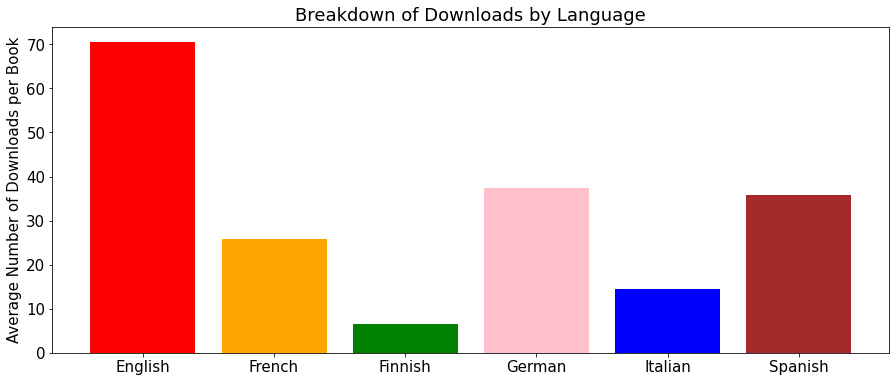

In [43]:
languages = ['English', 'French', 'Finnish', 'German', 'Italian', 'Spanish']
demands = []
c = ['red', 'orange', 'green', 'pink', 'blue', 'brown']
for language in languages:
    demands.append(df[df['Language'] == language]['Num_Downloads'].sum() / len(df[df['Language'] == language]))
    
fig8, ax8 = plt.subplots(1, 1, figsize=(15, 6))
ax8.bar(languages, demands, color = c)
ax8.set_ylabel('Average Number of Downloads per Book')
ax8.set_title('Breakdown of Downloads by Language');
    

## Number of Books Overtime

Lastly, I would like to take a look at the 'progress' that the website has made. The goal of the website is to make as many books as possible available to the public. Luckily, for each entry on the website, they mark the date on which the book was uploaded to the website. Therefore, we can plot how many books are on the website as a function of time. I have chosen to both break this down by language and to not in order to give a complete picture of the website's progress. 

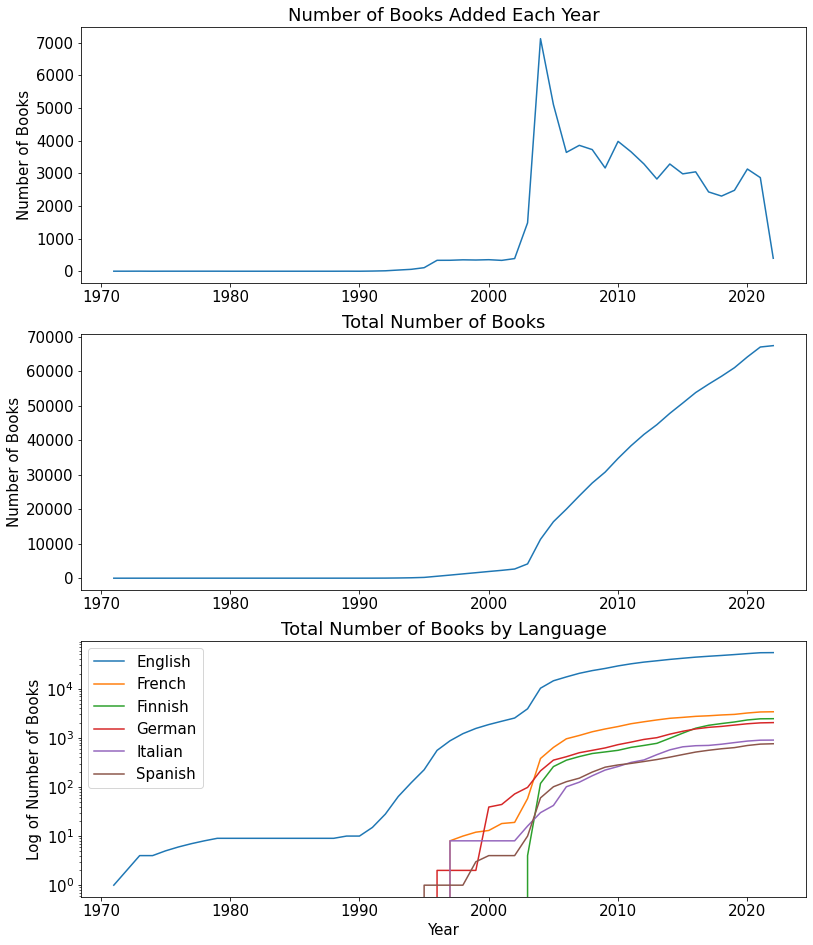

In [44]:
languages = ['English', 'French', 'Finnish', 'German', 'Italian', 'Spanish']
fig7, ax7 = plt.subplots(3, 1, figsize=(13, 16))
years = range(1971, 2023)
ordered_release = df['Release_Date'].sort_values()
year_dict = OrderedDict().fromkeys(years, 0)
for row in ordered_release:
    year = row[:row.index('-')]
    year_dict[int(year)] += 1



cum_sum = []
sum = 0
for item in year_dict.values():
    sum += item
    cum_sum.append(sum)


ax7[0].plot(years, year_dict.values())
ax7[1].plot(years, cum_sum)
ax7[0].set_title('Number of Books Added Each Year')
ax7[1].set_title('Total Number of Books')
ax7[2].set_title('Total Number of Books by Language')
ax7[0].set_ylabel('Number of Books')
ax7[1].set_ylabel('Number of Books')
ax7[2].set_ylabel('Log of Number of Books')
ax7[2].set_xlabel('Year')

for language in languages:
    ordered_release = df[df['Language'] == language]['Release_Date'].sort_values()
    year_dict = OrderedDict().fromkeys(years, 0)
    for row in ordered_release:
        year = row[:row.index('-')]
        year_dict[int(year)] += 1


    cum_sum = []
    sum = 0
    for item in year_dict.values():
        sum += item
        cum_sum.append(sum)
    
    ax7[2].plot(years,cum_sum)


ax7[2].legend(languages)
ax7[2].set_yscale('log')